# Customer Segmentation using Bayesian Clustering

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

plt.style.use('ggplot')

In [2]:
DATA_DIRECTORY = 'dataset/csv'

aisles = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'aisles.csv')
    )

departments = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'departments.csv')
    )

order_products_prior = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'order_products__prior.csv')
    )
orders = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'orders.csv')
    )

products = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'products.csv')
                       )


# Preprocessing / Feature Engineering 

First, let's merge the dataframes together so that we have all the information we need in one place


In [3]:
# First, let's merge the dataframes together so that we have all the information we need in one place
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
orders_with_product_info = pd.merge(orders, order_products_prior, on='order_id', how='left')


**We can now aggregate the data at the customer level and create some features to segment our customers**
  - Number of orders
  - Average days between orders
  - Average basket size
  - Favourite department
  - Number of unique products purchased
  - Reordered ratio
  - Most frequently purchased product
  - Number of orders with no days since prior order
  - Time of day preference for ordering
  - Day of week preference for ordering

In [4]:
# Total number of orders
total_orders = orders.groupby('user_id')['order_number'].max().reset_index()
total_orders.columns = ['user_id', 'total_orders']
total_orders.head()

,user_id,total_orders
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [5]:
# Average days between orders
average_days_between_orders = orders.groupby('user_id')['days_since_prior_order'].mean().round(0).reset_index()
average_days_between_orders.columns = ['user_id', 'average_days_between_orders']
# average_days_between_orders['average_days_between_orders'] = average_days_between_orders['average_days_between_orders'].apply(lambda x: np.round(x,0))
average_days_between_orders.head()

,user_id,average_days_between_orders
0,1,19.0
1,2,16.0
2,3,12.0
3,4,17.0
4,5,12.0


In [6]:
# Average basket size
average_basket_size = orders_with_product_info.groupby(['user_id', 'order_id'])['product_id'].count().groupby('user_id').mean().round(0).reset_index()
average_basket_size.columns = ['user_id', 'average_basket_size']
average_basket_size.head()

,user_id,average_basket_size
0,1,5.0
1,2,13.0
2,3,7.0
3,4,3.0
4,5,7.0


In [11]:
# Favourite department

favorite_department = orders_with_product_info.groupby(['user_id', 'department'])['product_id'].count().reset_index()
favorite_department = favorite_department.sort_values(by=['user_id', 'product_id'], ascending=False).groupby(['user_id']).first().reset_index()[['user_id', 'department']]
favorite_department.columns = ['user_id', 'favorite_department']
favorite_department.head()

,user_id,favorite_department
0,1,snacks
1,2,dairy eggs
2,3,produce
3,4,beverages
4,5,produce


In [13]:
# Number of unique products ordered
unique_products = orders_with_product_info.groupby('user_id')['product_id'].nunique().reset_index()
unique_products.columns = ['user_id', 'unique_products']
unique_products.head()

,user_id,unique_products
0,1,18
1,2,102
2,3,33
3,4,17
4,5,23


In [16]:
# How often a customer order is a reorder
reorder_ratio = orders_with_product_info.groupby('user_id')['reordered'].mean().round(3).reset_index()
reorder_ratio.columns = ['user_id', 'reorder_ratio']
reorder_ratio.head()

,user_id,reorder_ratio
0,1,0.695
1,2,0.477
2,3,0.625
3,4,0.056
4,5,0.378


In [18]:
# Most frequently bought products
frequent_product = orders_with_product_info.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
frequent_product = frequent_product.sort_values(by=['user_id', 'order_id'], ascending=False).groupby(['user_id']).first().reset_index()[['user_id', 'product_id']]
frequent_product.columns = ['user_id', 'frequent_product_id']
frequent_product.head()

,user_id,frequent_product_id
0,1,196.0
1,2,32792.0
2,3,39190.0
3,4,35469.0
4,5,11777.0


In [19]:
# how often a customer orders multiple times a day
same_day_orders = orders[orders['days_since_prior_order'] == 0].groupby('user_id')['order_id'].count().reset_index()
same_day_orders.columns = ['user_id', 'same_day_orders']
same_day_orders.head()

,user_id,same_day_orders
0,1,1
1,4,1
2,17,1
3,24,1
4,27,7


In [27]:
order_hour_of_day = orders.groupby('user_id')['order_hour_of_day'].apply(lambda x: x.mode()[0]).reset_index()
order_hour_of_day.columns = ['user_id', 'average_order_hour_of_day']
order_hour_of_day.head()

,user_id,average_order_hour_of_day
0,1,7
1,2,10
2,3,16
3,4,11
4,5,18


In [26]:
order_day_of_week = orders.groupby('user_id')['order_dow'].apply(lambda x: x.mode()[0]).reset_index()
order_day_of_week.columns = ['user_id', 'average_order_day_of_week']
order_day_of_week.head()


,user_id,average_order_day_of_week
0,1,4
1,2,1
2,3,0
3,4,4
4,5,0


In [73]:
# List all the dataframes you created
dfs = [total_orders, average_days_between_orders, average_basket_size, 
       favorite_department, unique_products, reorder_ratio, 
       frequent_product, same_day_orders, order_hour_of_day, 
       order_day_of_week ]

# Use the reduce function to merge all dataframes
from functools import reduce

df_final = reduce(lambda left,right: pd.merge(left,right,on='user_id'), dfs)

# Check the result
df_final.head()

,user_id,total_orders,average_days_between_orders,average_basket_size,favorite_department,unique_products,reorder_ratio,frequent_product_id,same_day_orders,average_order_hour_of_day,average_order_day_of_week
0,1,11,19.0,5.0,snacks,18,0.695,196.0,1,7,4
1,4,6,17.0,3.0,beverages,17,0.056,35469.0,1,11,4
2,17,41,8.0,7.0,beverages,83,0.718,7350.0,1,12,1
3,24,19,15.0,2.0,beverages,18,0.526,31222.0,1,8,0
4,27,82,4.0,9.0,beverages,220,0.714,2966.0,7,14,2


We would like to pass this data in a mahcine learning model so we need to prepare it so the model can understand the data. <br> First we will normalize/standardize or data.

In [74]:
df_final = pd.get_dummies(df_final, columns=['favorite_department'])

# convert the columns from True/False to 1/0
cols_to_convert = [col for col in df_final.columns if col.startswith('favorite_department_')]
for col in cols_to_convert:
    df_final[col] = df_final[col].astype(int)

df_final

,user_id,total_orders,average_days_between_orders,average_basket_size,unique_products,reorder_ratio,frequent_product_id,same_day_orders,average_order_hour_of_day,average_order_day_of_week,...,favorite_department_frozen,favorite_department_household,favorite_department_international,favorite_department_meat seafood,favorite_department_other,favorite_department_pantry,favorite_department_personal care,favorite_department_pets,favorite_department_produce,favorite_department_snacks
0,1,11,19.0,5.0,18,0.695,196.0,1,7,4,...,0,0,0,0,0,0,0,0,0,1
1,4,6,17.0,3.0,17,0.056,35469.0,1,11,4,...,0,0,0,0,0,0,0,0,0,0
2,17,41,8.0,7.0,83,0.718,7350.0,1,12,1,...,0,0,0,0,0,0,0,0,0,0
3,24,19,15.0,2.0,18,0.526,31222.0,1,8,0,...,0,0,0,0,0,0,0,0,0,0
4,27,82,4.0,9.0,220,0.714,2966.0,7,14,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33212,206199,20,17.0,16.0,134,0.590,24708.0,1,13,2,...,0,0,0,0,0,0,0,0,0,1
33213,206200,24,9.0,12.0,95,0.659,47209.0,2,19,1,...,0,0,0,0,0,0,0,0,1,0
33214,206201,33,11.0,12.0,174,0.569,23909.0,1,15,0,...,0,0,0,0,0,0,0,0,0,0
33215,206206,68,4.0,4.0,150,0.474,38530.0,5,18,0,...,1,0,0,0,0,0,0,0,0,0


In [95]:
df_final.columns

Index(['user_id', 'total_orders', 'average_days_between_orders',
       'average_basket_size', 'unique_products', 'reorder_ratio',
       'frequent_product_id', 'same_day_orders', 'average_order_hour_of_day',
       'average_order_day_of_week', 'favorite_department_alcohol',
       'favorite_department_babies', 'favorite_department_bakery',
       'favorite_department_beverages', 'favorite_department_breakfast',
       'favorite_department_bulk', 'favorite_department_canned goods',
       'favorite_department_dairy eggs', 'favorite_department_deli',
       'favorite_department_dry goods pasta', 'favorite_department_frozen',
       'favorite_department_household', 'favorite_department_international',
       'favorite_department_meat seafood', 'favorite_department_other',
       'favorite_department_pantry', 'favorite_department_personal care',
       'favorite_department_pets', 'favorite_department_produce',
       'favorite_department_snacks'],
      dtype='object')

In [78]:
df_columns_dist = ['total_orders', 'average_days_between_orders',
                   'average_basket_size', 'unique_products', 'reorder_ratio',
                   'same_day_orders', 'average_order_hour_of_day',
                   'average_order_day_of_week']

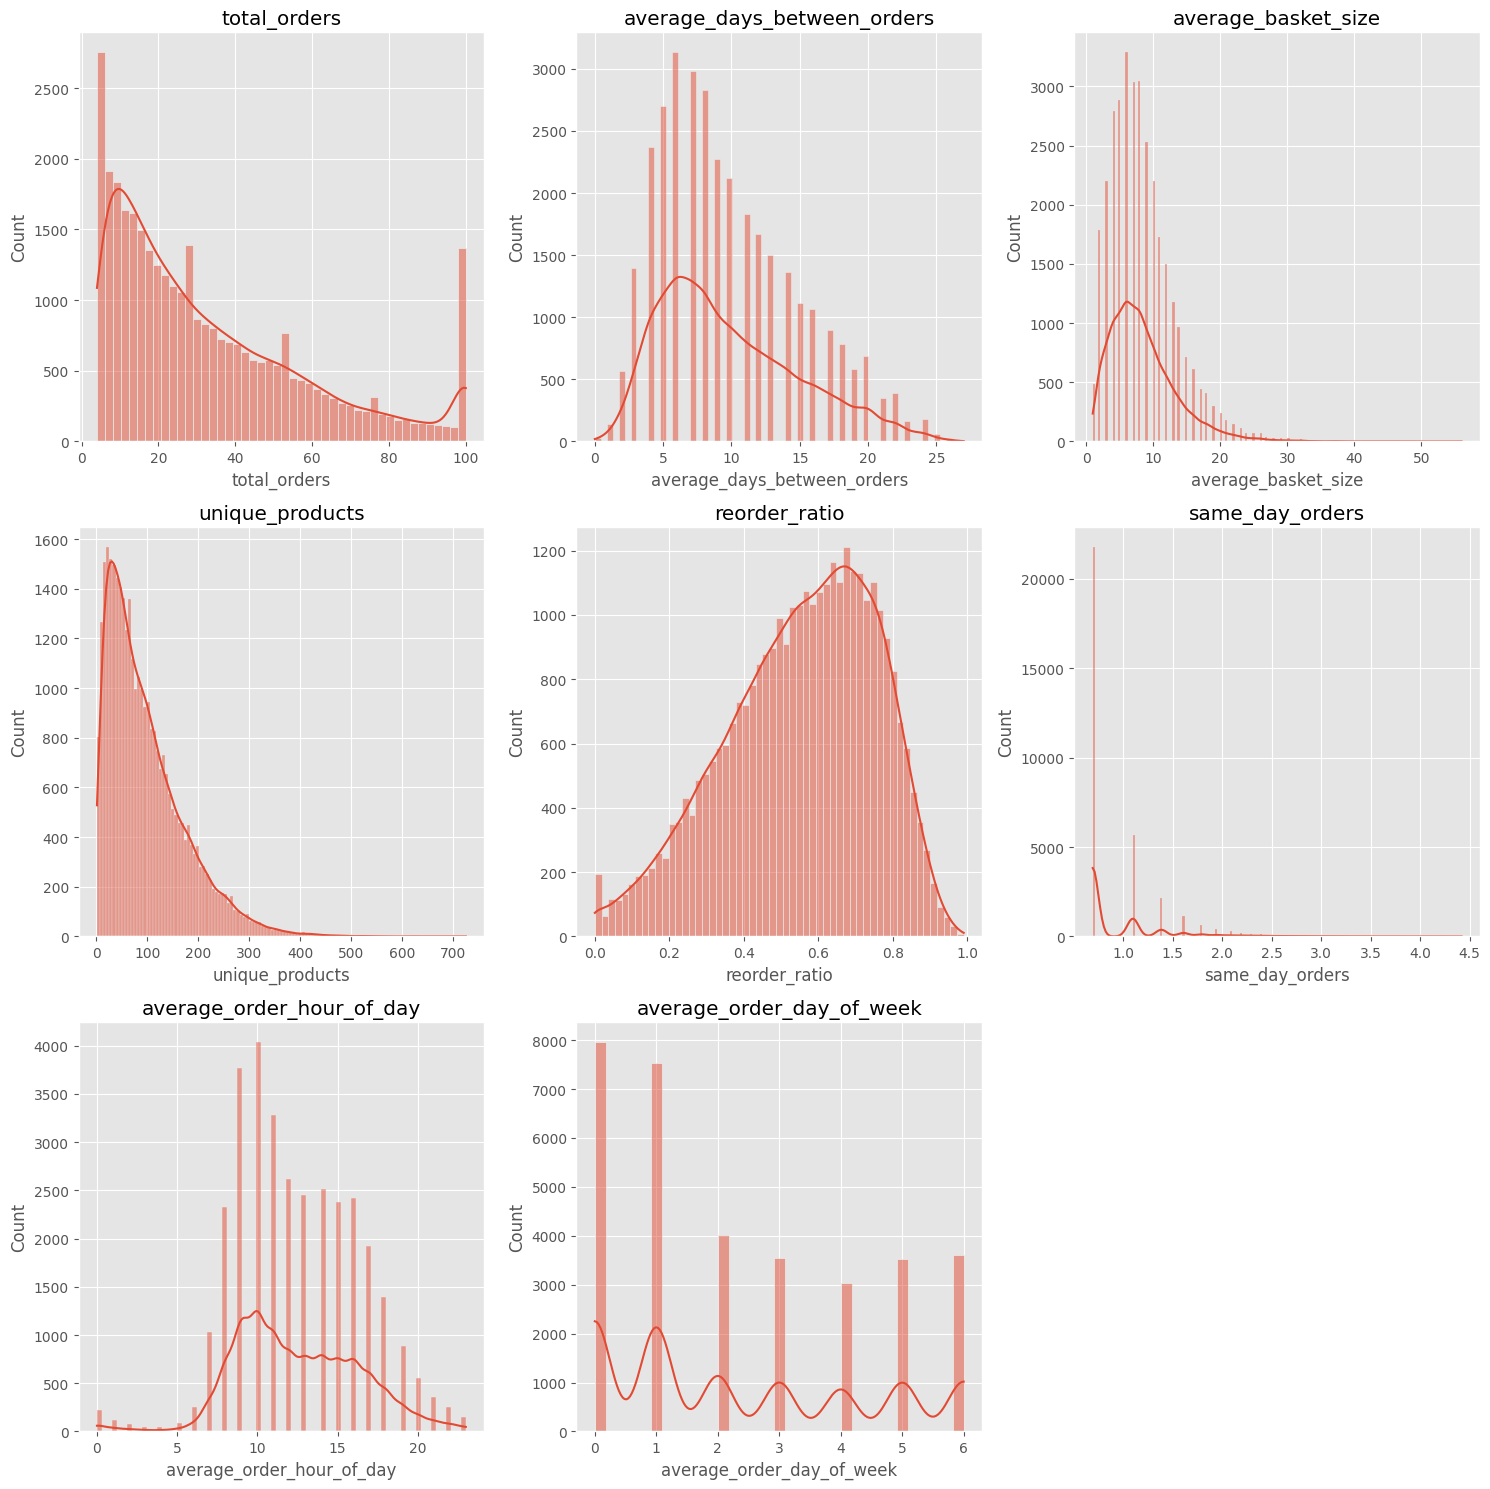

In [90]:

fig, axs = plt.subplots(3, 3, figsize=(15,15))

# Flatten the axes so we can easily iterate over them
axs = axs.flatten()

# Plot a histogram with a KDE for each column
for i, column in enumerate(df_columns_dist):
    sns.histplot(df_final[column], bins='auto', kde=True, ax=axs[i])
    axs[i].set_title(column)

# If the number of columns is less than 9, we can remove the extra subplots
if len(df_columns_dist) < 9:
    for i in range(len(df_columns_dist), 9):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [85]:
# Add a small constant to avoid taking log of zero
df_final['same_day_orders'] = np.log(df_final['same_day_orders'] + 1)

In [87]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_final.drop('user_id', axis=1)), 
                             columns=df_final.columns[1:], index=df_final.index)

df_normalized.head()

,total_orders,average_days_between_orders,average_basket_size,unique_products,reorder_ratio,frequent_product_id,same_day_orders,average_order_hour_of_day,average_order_day_of_week,favorite_department_alcohol,...,favorite_department_frozen,favorite_department_household,favorite_department_international,favorite_department_meat seafood,favorite_department_other,favorite_department_pantry,favorite_department_personal care,favorite_department_pets,favorite_department_produce,favorite_department_snacks
0,0.072917,0.703704,0.072727,0.023448,0.702020,0.003925,0.00000,0.304348,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.020833,0.629630,0.036364,0.022069,0.056566,0.713900,0.00000,0.478261,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.385417,0.296296,0.109091,0.113103,0.725253,0.147921,0.00000,0.521739,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.156250,0.555556,0.018182,0.023448,0.531313,0.628417,0.00000,0.347826,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.812500,0.148148,0.145455,0.302069,0.721212,0.059680,0.37209,0.608696,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


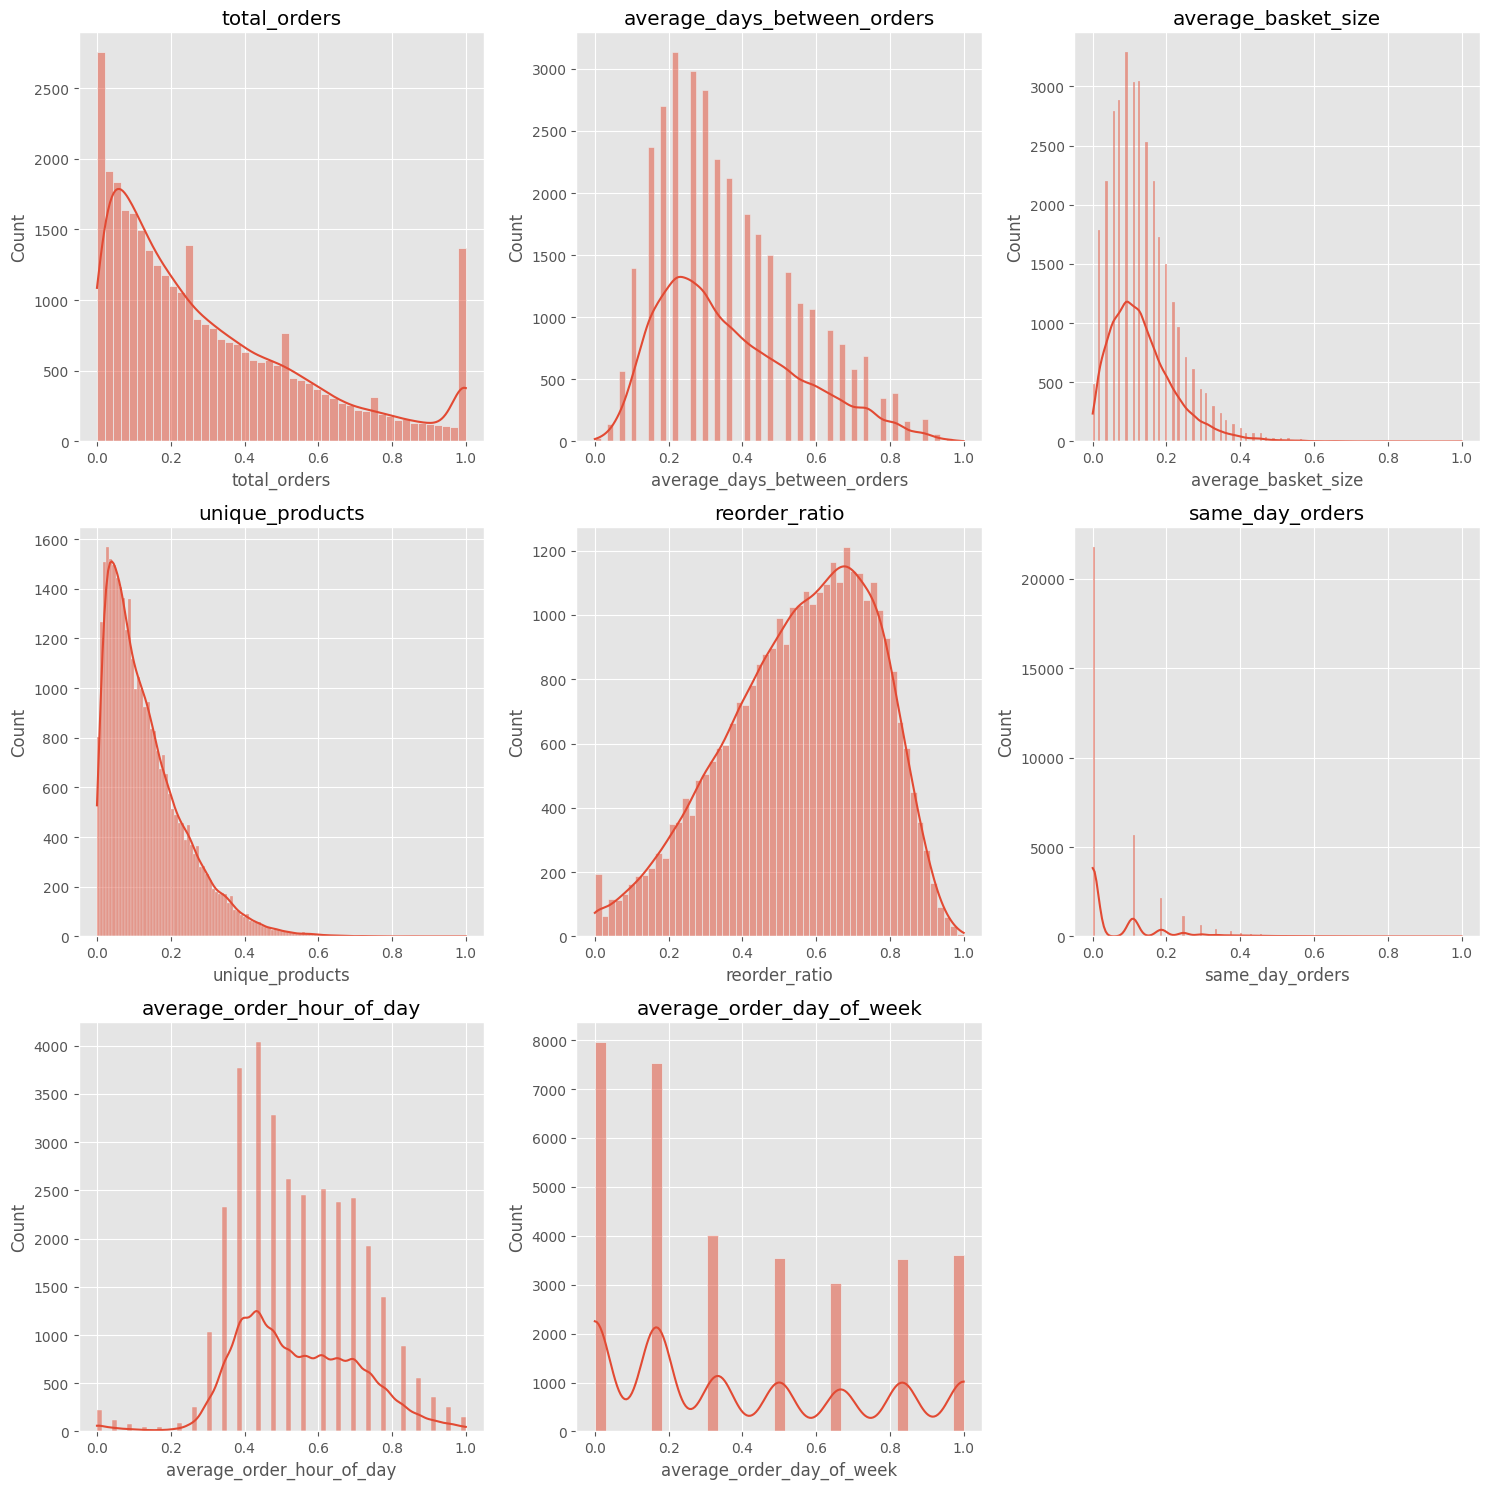

In [92]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))

# Flatten the axes so we can easily iterate over them
axs = axs.flatten()

# Plot a histogram with a KDE for each column
for i, column in enumerate(df_columns_dist):
    sns.histplot(df_normalized[column], bins='auto', kde=True, ax=axs[i])
    axs[i].set_title(column)

# If the number of columns is less than 9, we can remove the extra subplots
if len(df_columns_dist) < 9:
    for i in range(len(df_columns_dist), 9):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


# Fit Model
Now our data is ready to pass through to our model.

In [97]:
df_normalized.columns

Index(['total_orders', 'average_days_between_orders', 'average_basket_size',
       'unique_products', 'reorder_ratio', 'frequent_product_id',
       'same_day_orders', 'average_order_hour_of_day',
       'average_order_day_of_week', 'favorite_department_alcohol',
       'favorite_department_babies', 'favorite_department_bakery',
       'favorite_department_beverages', 'favorite_department_breakfast',
       'favorite_department_bulk', 'favorite_department_canned goods',
       'favorite_department_dairy eggs', 'favorite_department_deli',
       'favorite_department_dry goods pasta', 'favorite_department_frozen',
       'favorite_department_household', 'favorite_department_international',
       'favorite_department_meat seafood', 'favorite_department_other',
       'favorite_department_pantry', 'favorite_department_personal care',
       'favorite_department_pets', 'favorite_department_produce',
       'favorite_department_snacks', 'cluster'],
      dtype='object')

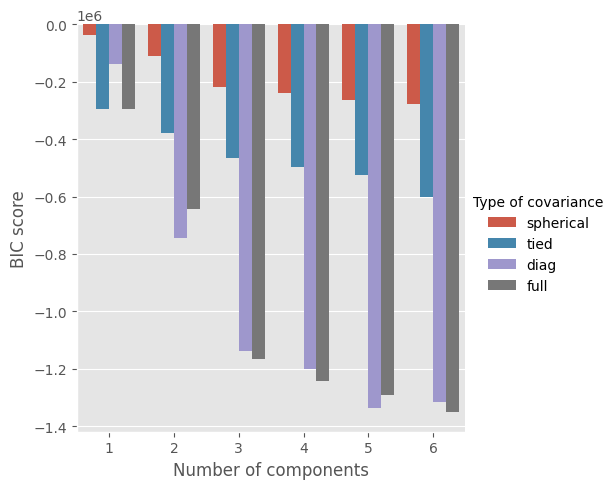

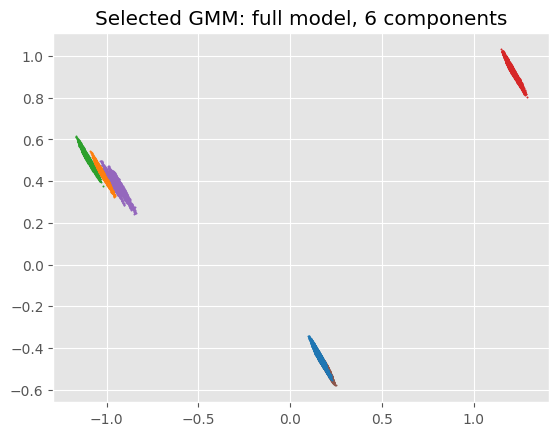

In [100]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse
from scipy import linalg
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# exclude 'user_id' and 'frequent_product_id'
# df_normalized = df_normalized.drop(columns=['user_id', 'frequent_product_id'])

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(df_normalized)

# Plot the BIC scores
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

# Plot the best model
color_iter = sns.color_palette("tab10", grid_search.best_params_['n_components'])[::-1]

from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)


Y_ = grid_search.predict(df_normalized)
fig, ax = plt.subplots()

for i, color in enumerate(color_iter):
    if not np.any(Y_ == i):
        continue
    plt.scatter(df_pca[Y_ == i, 0], df_pca[Y_ == i, 1], 0.8, color=color)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.show()

>This code will output a bar graph where the x-axis represents the number of components (i.e., clusters), the y-axis represents the BIC score, and each bar is colored by the type of covariance. The covariance type and number of clusters that result in the lowest BIC score represent the best model【90†source】【91†source】【The final plot visualizes the chosen model, using ellipses to represent the Gaussian components of the model. The number of ellipses should match the optimal number of clusters that were determined by the BIC score【92†source】.

>Please note that for high-dimensional data, this plotting technique might not be as informative because it's only able to represent two dimensions. Therefore, you may want to use dimensionality reduction techniques like PCA (Principal Component Analysis) to visualize your clusters in a lower-dimensional space.

>Also, be aware that GMM assumes that the data is normally distributed, which might not be the case for your dataset. If your data is not normally distributed, other clustering techniques, such as K-Means or DBSCAN, might yield better results.

>Remember to adjust the range in param_grid for the n_components (i.e., the number of clusters) based on your specific needs. The range provided in this example (1 to 6) might not be suitable for your dataset. You should choose a range that makes sense given your understanding of the data and the problem at hand.